In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import sys
#sys.path.append("/ahg/regevdata/projects/Cell2CellCommunication/code/MIMOSCA")
import perturbseq as perturb

%matplotlib inline
import matplotlib.pyplot as plt


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=200, color_map='viridis')
sc.logging.print_versions()
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.7.2
sinfo       0.3.4
-----
PIL                 8.2.0
anyio               NA
appnope             0.1.2
attr                20.3.0
babel               2.9.0
backcall            0.2.0
bottleneck          1.3.2
brotli              NA
cairo               1.20.1
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask  

In [2]:
#combo data
COMBO_DATA="/Users/ursuo/Documents/research/baf/data/2021-06-17/combo2"
adata=sc.read(COMBO_DATA+'/Baf_combo.analysis.2021-06-17.h5ad')
adata

Only considering the two last: ['.2021-06-17', '.h5ad'].
Only considering the two last: ['.2021-06-17', '.h5ad'].


AnnData object with n_obs × n_vars = 6319 × 18332
    obs: 'batch', 'SMARCC1_7', 'GLTSCR1_1', 'BCL7B_1', 'SMARCD1_4', 'DPF2_4', 'BRD9_2', 'BCL7C_2', 'SS18_2', 'GLTSCR1L_3', 'PHF10_1', 'NTC7_IG1144056', 'ARID2_1', 'SMARCD2_3', 'SMARCA2_4', 'ARID1B_4', 'BCL7A_3', 'SMARCC2_3', 'SMARCE1_1', 'NTC1_IG345439', 'SMARCB1_5', 'BRD7_2', 'SMARCA4_4', 'NTC6_IG1216445', 'SS18L_1', 'PBRM1_3', 'ARID1A_3', 'gene.cell', 'gene.BCL7A', 'gene.ARID2', 'gene.ARID1A', 'gene.PHF10', 'gene.GLTSCR1L', 'gene.SS18', 'gene.DPF2', 'gene.SMARCA4', 'gene.BCL7B', 'gene.SMARCC2', 'gene.SS18L', 'gene.SMARCA2', 'gene.SMARCD2', 'gene.SMARCB1', 'gene.GLTSCR1', 'gene.NTC', 'gene.SMARCD1', 'gene.ARID1B', 'gene.BRD9', 'gene.BRD7', 'gene.SMARCE1', 'gene.PBRM1', 'gene.SMARCC1', 'gene.BCL7C', 'guide', 'guide.compact', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '1', '2', '0', 'louvain', 'NTC1', 'PHF10', 'GLTSCR1', 'SMARCA2', 'GLTSCR1L', 'SMARCC1', 'BRD7', 'BCL7B', 'ARID1B', 'BRD9', 'ARID1A'

In [3]:
def DE(adata_here,reference,groupby,fdr=0.01,use_raw=False,compute_lfc=False):

    if use_raw:
        genes=adata_here.raw.var_names
    else:
        genes=adata_here.var_names
        
    groupby_options=list(set(adata_here.obs[groupby]).difference(set([reference])))

    sc.tl.rank_genes_groups(adata_here,groupby=groupby,n_genes=len(genes), 
                            reference=reference,
                            use_raw=use_raw,rankby_abs=True,
                            method='t-test_overestim_var',
                            #corr_method='bonferroni',
                           )

    pval_mat=pd.DataFrame(index=groupby_options,columns=genes,dtype=float)
    sign_mat=pd.DataFrame(index=groupby_options,columns=genes,dtype=float)
    
    #bulkify
    bulk=perturb.tl.bulk(adata_here,grouping_variable=groupby,by_batch=False,
                         return_matrix=True)
    #subtract the control from the bulk to get the sign
    sign_mat_full=bulk-bulk.loc[reference,:]
    
    if compute_lfc:
        lfc_mat=pd.DataFrame(index=groupby_options,columns=genes,dtype=float)
    
    for groupby_option in groupby_options:
        if groupby_option==reference:
            continue
        df_here=sc.get.rank_genes_groups_df(adata_here,group=groupby_option)
        df_here.index=list(df_here['names'])
        #pvalue
        pval_mat.loc[groupby_option,:]=df_here.loc[genes,'pvals_adj']
        if compute_lfc:
            lfc_mat.loc[groupby_option,:]=df_here.loc[genes,'logfoldchanges']
        sign_mat.loc[groupby_option,:]=np.sign(sign_mat_full.loc[groupby_option,genes])
        
    signed_pval_mat=pd.DataFrame(np.multiply(-np.log10(pval_mat),np.sign(sign_mat)),
                                 index=groupby_options,columns=genes,dtype=float)
    return(signed_pval_mat)

In [4]:
fdr=0.01
gene_guides=['ARID1A', 'ARID1B','ARID1A,ARID1B']
x='3'
DATA="/Users/ursuo/Documents/research/baf/data/2022-03-27/combo2"
FIGS="/Users/ursuo/Documents/research/baf/data/2022-03-27/Figures/"
pref=DATA+'/combo2.iter.'+x
print(pref)

modelname='___'.join(gene_guides)

/Users/ursuo/Documents/research/baf/data/2022-03-27/combo2/combo2.iter.3


In [5]:
pval_mat=DE(adata,'control',groupby='gene2',fdr=fdr,use_raw=True,compute_lfc=True)

ranking genes
... storing 'SMARCC1_7' as categorical
... storing 'GLTSCR1_1' as categorical
... storing 'BCL7B_1' as categorical
... storing 'SMARCD1_4' as categorical
... storing 'DPF2_4' as categorical
... storing 'BRD9_2' as categorical
... storing 'BCL7C_2' as categorical
... storing 'SS18_2' as categorical
... storing 'GLTSCR1L_3' as categorical
... storing 'PHF10_1' as categorical
... storing 'NTC7_IG1144056' as categorical
... storing 'ARID2_1' as categorical
... storing 'SMARCD2_3' as categorical
... storing 'SMARCA2_4' as categorical
... storing 'ARID1B_4' as categorical
... storing 'BCL7A_3' as categorical
... storing 'SMARCC2_3' as categorical
... storing 'SMARCE1_1' as categorical
... storing 'NTC1_IG345439' as categorical
... storing 'SMARCB1_5' as categorical
... storing 'BRD7_2' as categorical
... storing 'SMARCA4_4' as categorical
... storing 'NTC6_IG1216445' as categorical
... storing 'SS18L_1' as categorical
... storing 'PBRM1_3' as categorical
... storing 'ARID1A_3' 

In [6]:
#get only DE genes

de_genes=list(pval_mat.loc[gene_guides,pval_mat.loc[gene_guides,:].abs().max(axis=0)>=-np.log10(fdr)].columns)
print(len(de_genes))
adata2=adata[:,de_genes]

2233


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn import linear_model
my_rng=np.random.RandomState(1234)
reg=linear_model.ElasticNet(l1_ratio=0.5,alpha=0.05,max_iter=10000,random_state=my_rng,selection='random')


perturb.lm.train_lm(adata2,
        lm=reg,
        include_expression=True,
        #y_obs=pcs,
        model_name=modelname,
        perturbations_list=gene_guides,
        covariates_list=[],
        my_rng=my_rng,
        adjust=False,
         adjust_vars=[],
        copy_adata=False,
        keep_unassigned=False,
         control_names=['control'],
       use_raw=False)

Trying to set attribute `.obs` of view, copying.


splitting train    5055
test      632
valid     632
Name: train_valid_test, dtype: int64
Found 2/3 perturbations
Found 0/0 obs
Found 0/0 covariates
(1242, 3) (1242, 0) (1242, 2233)
train    5055
test      632
valid     632
Name: PS.ARID1A___ARID1B___ARID1A,ARID1B.train_valid_test, dtype: int64
train 1002
valid 109
test 131

Fitting model
 ElasticNet(alpha=0.05, max_iter=10000,
           random_state=RandomState(MT19937) at 0x7FD25ED12140,
           selection='random')
training [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 32, 33, 34, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 74, 76, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 96, 97, 98, 99, 100, 101, 103, 104, 105, 107, 108, 109, 110, 111, 112, 114, 115, 117, 118, 119, 120, 121, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 

In [8]:
coef=adata2.uns['PS.'+modelname+'.coef']
#coef=adata2.obs['PS.'+modelname+'.train_valid_test']
coef.to_csv(pref+'coef'+x+'.csv')

In [9]:
coef1=pd.read_csv(DATA+'/combo2.iter.1coef1.csv')
coef2=pd.read_csv(DATA+'/combo2.iter.2coef2.csv')
coef2=pd.read_csv(DATA+'/combo2.iter.3coef3.csv')

In [10]:
(coef1!=coef2).sum()

Unnamed: 0       0
ARID1A           0
ARID1B           0
ARID1A,ARID1B    0
dtype: int64

In [11]:
(coef1==coef2).sum()

Unnamed: 0       2233
ARID1A           2233
ARID1B           2233
ARID1A,ARID1B    2233
dtype: int64

In [12]:
coef1.head()

,Unnamed: 0,ARID1A,ARID1B,"ARID1A,ARID1B"
0,DCXR,-0.01157,-0.0,-0.10353
1,EXOSC5,-0.25857,0.0,-0.11262
2,STOM,-0.11072,0.0,-0.07493
3,PDIA6,-0.44811,0.0,-0.09111
4,LRR1,-0.26666,0.0,-0.11775


In [13]:
coef2.head()

,Unnamed: 0,ARID1A,ARID1B,"ARID1A,ARID1B"
0,DCXR,-0.01157,-0.0,-0.10353
1,EXOSC5,-0.25857,0.0,-0.11262
2,STOM,-0.11072,0.0,-0.07493
3,PDIA6,-0.44811,0.0,-0.09111
4,LRR1,-0.26666,0.0,-0.11775


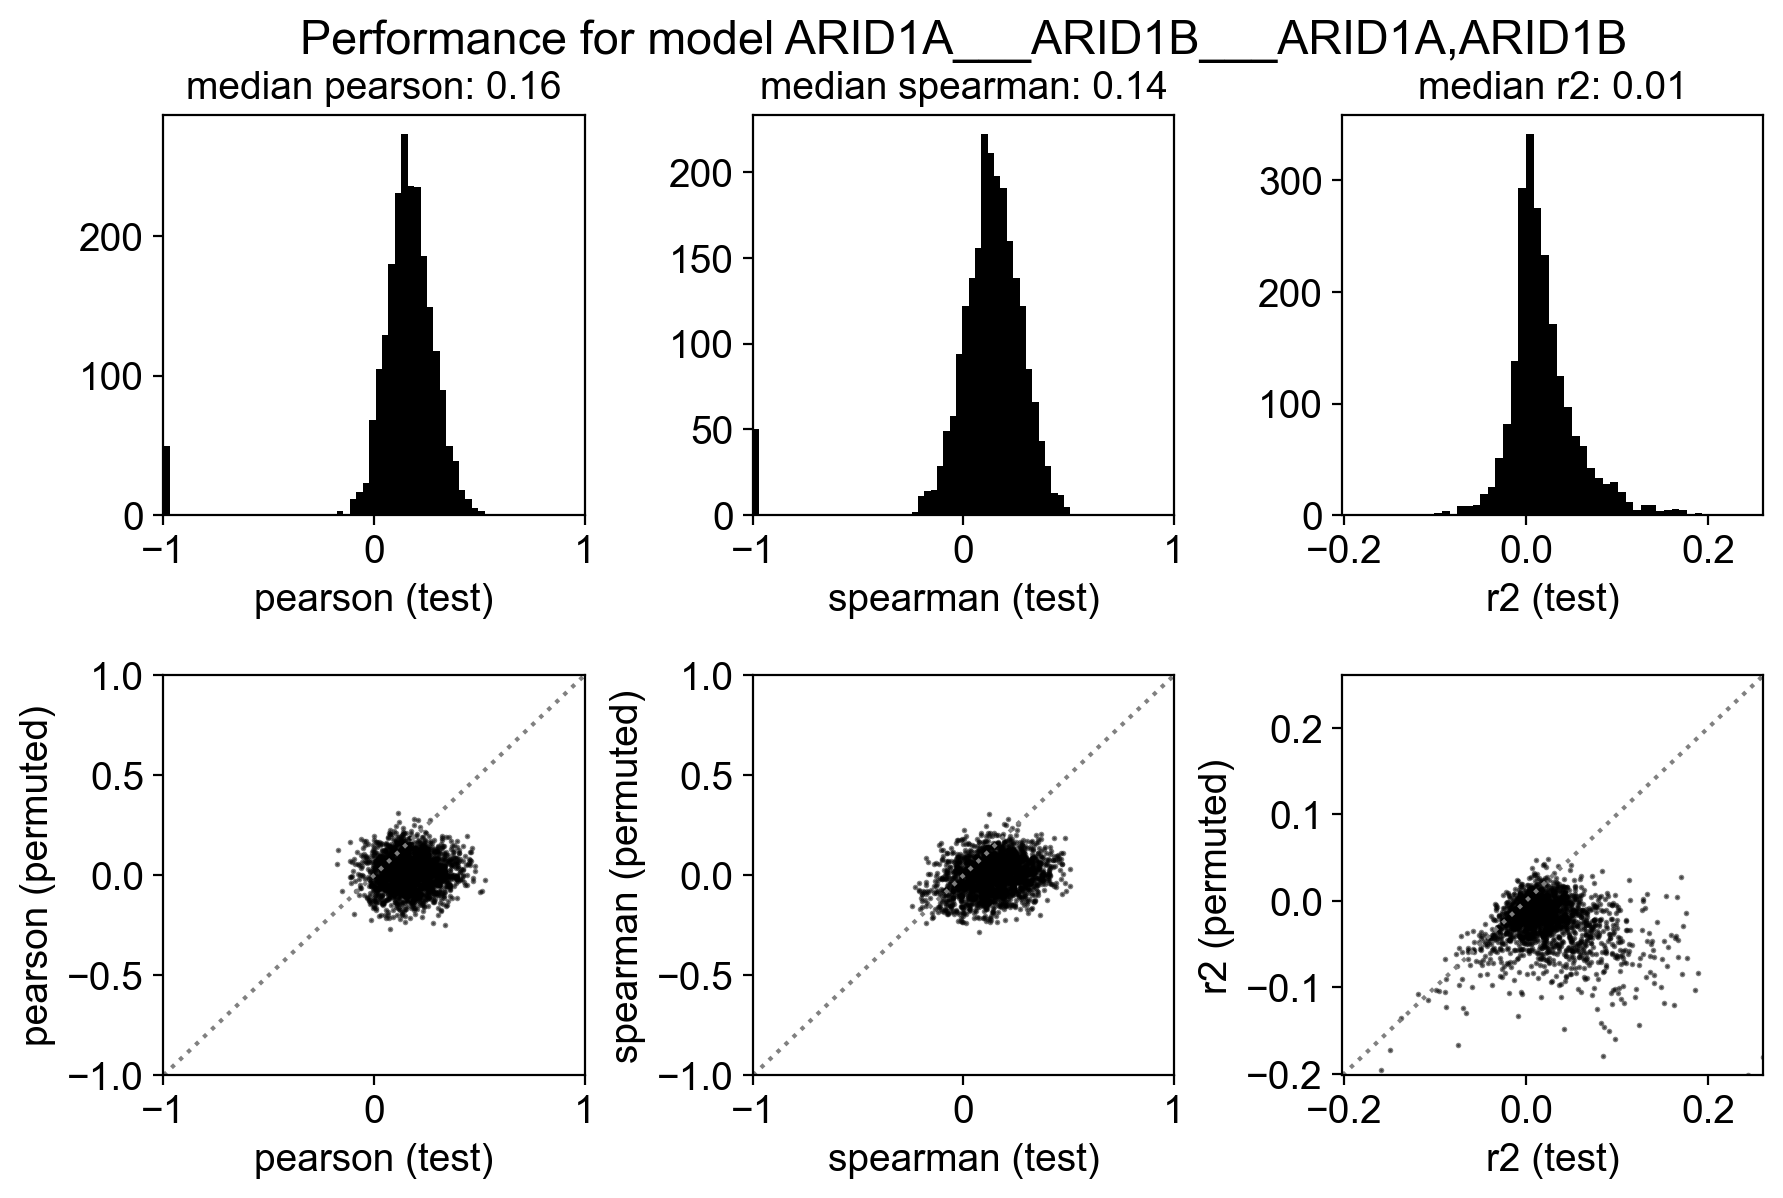

In [16]:
perturb.pl.plot_model_performance(adata2,modelname)

In [14]:
adata2

AnnData object with n_obs × n_vars = 6319 × 2233
    obs: 'batch', 'SMARCC1_7', 'GLTSCR1_1', 'BCL7B_1', 'SMARCD1_4', 'DPF2_4', 'BRD9_2', 'BCL7C_2', 'SS18_2', 'GLTSCR1L_3', 'PHF10_1', 'NTC7_IG1144056', 'ARID2_1', 'SMARCD2_3', 'SMARCA2_4', 'ARID1B_4', 'BCL7A_3', 'SMARCC2_3', 'SMARCE1_1', 'NTC1_IG345439', 'SMARCB1_5', 'BRD7_2', 'SMARCA4_4', 'NTC6_IG1216445', 'SS18L_1', 'PBRM1_3', 'ARID1A_3', 'gene.cell', 'gene.BCL7A', 'gene.ARID2', 'gene.ARID1A', 'gene.PHF10', 'gene.GLTSCR1L', 'gene.SS18', 'gene.DPF2', 'gene.SMARCA4', 'gene.BCL7B', 'gene.SMARCC2', 'gene.SS18L', 'gene.SMARCA2', 'gene.SMARCD2', 'gene.SMARCB1', 'gene.GLTSCR1', 'gene.NTC', 'gene.SMARCD1', 'gene.ARID1B', 'gene.BRD9', 'gene.BRD7', 'gene.SMARCE1', 'gene.PBRM1', 'gene.SMARCC1', 'gene.BCL7C', 'guide', 'guide.compact', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '1', '2', '0', 'louvain', 'NTC1', 'PHF10', 'GLTSCR1', 'SMARCA2', 'GLTSCR1L', 'SMARCC1', 'BRD7', 'BCL7B', 'ARID1B', 'BRD9', 'ARID1A',

In [ ]:
coef1==coef2

In [ ]:
(coef1.iloc[:,1:4]-coef2.iloc[:,1:4]).sum()

In [ ]:
coef1.round(5)

In [ ]:
my_rng.permutation(range(10))

In [ ]:
my_rng.permutation(range(10))

In [ ]:
my_rng

In [ ]:
np.random.RandomState(1234).permutation(range(10))

In [ ]:
np.random.RandomState(1234).permutation(range(10))

In [ ]:
adata

In [ ]:
adata.obs['gene2'].value_counts().median()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn import linear_model
my_rng=np.random.RandomState(1234)
reg=linear_model.ElasticNet(l1_ratio=0.5,alpha=0.05,max_iter=10000,random_state=my_rng,selection='random')

X=adata2.uns['PS.'+modelname+'test1.X']
y=adata2.uns['PS.'+modelname+'test1.y']

reg.fit(X,y)
coef=reg.coef_
pd.DataFrame(coef).to_csv('coef1.csv')





my_rng=np.random.RandomState(1234)
reg=linear_model.ElasticNet(l1_ratio=0.5,alpha=0.05,max_iter=10000,random_state=my_rng,selection='random')

X=adata2.uns['PS.'+modelname+'test2.X']
y=adata2.uns['PS.'+modelname+'test2.y']

reg.fit(X,y)
coef=reg.coef_
pd.DataFrame(coef).to_csv('coef2.csv')

In [ ]:
coef1=pd.read_csv('coef1.csv')
coef2=pd.read_csv('coef2.csv')

In [ ]:
(coef1!=coef2).sum()

In [ ]:
(coef1==coef2).sum()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn import linear_model
my_rng=np.random.RandomState(1234)
reg=linear_model.ElasticNet(l1_ratio=0.5,alpha=0.05,max_iter=10000,random_state=my_rng,selection='random')


perturb.lm.train_lm(adata2,
        lm=reg,
        include_expression=True,
        #y_obs=pcs,
        model_name=modelname+'test1',
        perturbations_list=gene_guides,
        covariates_list=[],
        my_rng=my_rng,
        adjust=False,
         adjust_vars=[],
        copy_adata=False,
        keep_unassigned=False,
         control_names=['control'],
       use_raw=False)

In [ ]:
my_rng=np.random.RandomState(1234)
reg=linear_model.ElasticNet(l1_ratio=0.5,alpha=0.05,max_iter=10000,random_state=my_rng,selection='random')

perturb.lm.train_lm(adata2,
        lm=reg,
        include_expression=True,
        #y_obs=pcs,
        model_name=modelname+'test2',
        perturbations_list=gene_guides,
        covariates_list=[],
        my_rng=my_rng,
        adjust=False,
         adjust_vars=[],
        copy_adata=False,
        keep_unassigned=False,
         control_names=['control'],
       use_raw=False)

In [ ]:
coef1=adata2.uns['PS.'+modelname+'test1.coef']
coef2=adata2.uns['PS.'+modelname+'test2.coef']

#coef1=adata2.uns['PS.'+modelname+'test1.y']
#coef2=adata2.uns['PS.'+modelname+'test2.y']

#coef1=adata2.obs['PS.'+modelname+'test1.train_valid_test']
#coef2=adata2.obs['PS.'+modelname+'test2.train_valid_test']

In [ ]:
coef1

In [ ]:
coef2

In [ ]:
(coef1!=coef2).sum()

In [ ]:
(coef1==coef2).sum()

In [ ]:
plt.scatter(coef1.iloc[:,1],coef2.iloc[:,1],s=5,color='black',alpha=0.05)
plt.grid(False)
#plt.xlim(-0.1,0.1)

In [ ]:
(coef2-coef1).abs().max()

In [ ]:
adata2

In [ ]:
coef=adata2.uns['PS.'+modelname+'.coef']
coef=adata2.obs['PS.'+modelname+'.train_valid_test']
coef.to_csv(pref+'coef'+x+'.csv')

In [ ]:
coef1=pd.read_csv(DATA+'/combo2.iter.1coef1.csv')
coef2=pd.read_csv(DATA+'/combo2.iter.2coef2.csv')

In [ ]:
(coef1!=coef2).sum()

In [ ]:
(coef1==coef2).sum()

In [ ]:
#hmm, so models between runs don't reproduce????

In [ ]:
coef1

In [ ]:
coef2

In [ ]:
import statsmodels   
from perturbseq.lm import _train_lm
from statsmodels.distributions.empirical_distribution import ECDF

    
def run_permuted_models(adata_here,
                        lm,
                       model_name='linear_model',
                       num_permutations=1,
                        rng=np.random.RandomState(1234),
                        adjust=False,
                       copy_adata=False):
    
    if copy_adata: adata_here = adata_here.copy()
        
    pref='PS.'+model_name
        
    if not adjust:
        try:
            xname='X'
            assert (pref+'.X' in adata_here.uns and pref+'.y' in adata_here.uns and pref+'.covariates' in adata_here.uns)
        except AssertionError:
            print('ERROR: '+'PS.'+model_name+'.X, y or covariates are missing. Run perturb.lm.train_lm() first')
            return
    else:
        try:
            xname='X_adjust'
            assert (pref+'.X_adjust' in adata_here.uns 
                and pref+'.y' in adata_here.uns 
                and pref+'.covariates' in adata_here.uns)
        except AssertionError:
                print('ERROR: '+'PS.'+model_name+'.X_adjust, y or covariates are missing. Run perturb.lm.train_lm() first')
                return
            
    
    #=====================
    #get permuted datasets
    #=====================
    print('== Permuting data')
    permuted_datasets={}
    for p in range(num_permutations):
        permuted_datasets[p]=pd.DataFrame(rng.permutation(np.array(adata_here.uns[pref+'.'+xname])),
                           index=adata_here.uns[pref+'.'+xname].index,
                           columns=adata_here.uns[pref+'.'+xname].columns)
    covariates=adata_here.uns[pref+'.covariates']
    
    
    X_df=adata_here.uns[pref+'.'+xname]
    X_cells=list(X_df.index)
    training=[cellidx for cellidx in range(X_df.shape[0]) if adata_here.obs[pref+'.train_valid_test'].loc[X_cells[cellidx]]=='train']
    
    for p in range(num_permutations):
        print('Running model on permuted data #'+str(p))
            
        X_plus_covariates=pd.concat([permuted_datasets[p],covariates],axis=1)
            
        #run the model
        perm_coef,perm_lm=_train_lm(X_plus_covariates,
                                   adata_here.uns[pref+'.y'],
                                   lm,
                                   training=training)
        
        if pref+'.perm'+str(p)+'.coef' in adata.uns:
            print('WARNING: Over-writing adata.uns["'+pref+'.perm'+str(p)+'.coef'+'"]')
        adata_here.uns[pref+'.perm'+str(p)+'.coef']=perm_coef
        if pref+'.perm'+str(p)+'.X' in adata.uns:
            print('WARNING: Over-writing adata.uns["'+pref+'.perm'+str(p)+'.X"]')
        adata_here.uns[pref+'.perm'+str(p)+'.X']=X_plus_covariates
            
    if copy_adata:
        return(adata_here)
    
    
    

In [ ]:
run_permuted_models(adata2,
                        lm=reg,
                       model_name=modelname,
                       num_permutations=10,
                    rng=my_rng,
                       copy_adata=False)

In [ ]:
def label_coefs_with_covariates(adata_here,coef,perturbations_obs,
                               gmeans=None,gvars=None):
    
    genes_used=list(set(adata_here.var_names).intersection(set(coef.index)))
    
    #get all gene expressions and variances
    if gmeans == None:
        gmeans=pd.DataFrame({'gene':genes_used,
                             'mean':np.mean(adata_here.raw[:,genes_used].X.toarray(),axis=0)},
                           index=genes_used)
    if gvars == None:
        gvars=pd.DataFrame({'gene':genes_used,
                            'var':np.var(adata_here.raw[:,genes_used].X.toarray(),axis=0)},
                          index=genes_used)
        
    
    coef_df=pd.DataFrame(columns=['guide','gene','beta','gene_mean','gene_var','cells_per_guide'])
    for col in coef.columns:
        coef_df_here=pd.DataFrame({'guide':col,
                                  'gene':list(coef.index),
                                   'beta':coef.loc[:,col],
                                   'gene_mean':gmeans.loc[coef.index,'mean'],
                                   'gene_var':gvars.loc[coef.index,'var'],
                                   'cells_per_guide':np.sum(adata_here.obs[perturbations_obs]==col),
                                  })
        coef_df=pd.concat([coef_df,coef_df_here])
    return(coef_df)

def coef_FDR(adata_here,
             perturbations_obs,
            model_name='linear_model',
             num_permutations=1,
             bins=[3,3,23,1000],
            copy_adata=False):
    
    import statsmodels
    from statsmodels.sandbox.stats.multicomp import fdrcorrection0
    from statsmodels.stats.multitest import multipletests

    
    if copy_adata: adata_here = adata_here.copy()
    
    print('== Computing coefficient significance')
    
    genes_used=list(set(adata_here.var_names).intersection(set(adata_here.uns['PS.'+model_name+'.y'].columns)))
    perturbations=adata_here.uns['PS.'+model_name+'.X'].columns
    
    B_real=label_coefs_with_covariates(adata_here,
                                    adata_here.uns['PS.'+model_name+'.coef'],
                           perturbations_obs=perturbations_obs)
    B_real['data']='real'
    
    fdrs=[]
    
    
    if len(genes_used)>0:
        #annotate permuted coefficients
        B_shuff_list=[]
        for p in range(num_permutations):
            B_shuff_here=label_coefs_with_covariates(adata_here,
                                                             adata_here.uns['PS.'+model_name+'.perm'+str(p)+'.coef'],
                           perturbations_obs=perturbations_obs)
            B_shuff_list.append(B_shuff_here)
        
        B_perm=pd.concat(B_shuff_list)
        B_perm['data']='perm'
        B_full=pd.concat([B_real,B_perm])
        
        #bin coefficients
        for covariate in ['gene_mean','gene_var','cells_per_guide']:
            #TODO: not hardcode this
            num_bins=1 
            B_full['bin.'+covariate]=pd.cut(B_full[covariate],
                                           bins=num_bins,labels=range(num_bins),
                                          )
        #name the bins
        B_full['bin']=B_full['bin.gene_mean'].astype(str)+B_full['bin.gene_var'].astype(str)+B_full['bin.cells_per_guide'].astype(str)
            
        B_perm=B_full.loc[B_full['data']=='perm',:]
        B_real=B_full.loc[B_full['data']=='real',:]
        bins=list(B_full['bin'].value_counts().index)
        
        for b in bins:
            #make ecdf
            B_perm_betas=np.abs(B_perm.loc[B_perm['bin']==b,'beta'])
            from statsmodels.distributions.empirical_distribution import ECDF
            ecdf_here=ECDF(B_perm_betas)
            fdr_here=pd.DataFrame(B_real.loc[B_real['bin']==b,:])
            probs=1-ecdf_here(np.abs(fdr_here['beta']))
            beta_sign=np.sign(fdr_here['beta'])
            #set pseudocount as smallest nonzero fdr
            fdr_here['FDR']=probs
            fdrs.append(fdr_here)
        fdrs=pd.concat(fdrs)
        print('fdr',fdrs['FDR'])
        ps=np.min(np.array(fdrs['FDR'])[np.nonzero(np.array(fdrs['FDR']))])
        fdrs['signed.-log10FDR']=np.sign(fdrs['beta'])*(-np.log10(multipletests(fdrs['FDR']+ps,method='fdr_bh')[1]))
        #reshape back the FDRs into a matrix
        fdr_mat=fdrs.pivot(index='gene', columns='guide', values='signed.-log10FDR')
    
    if 'PS.'+model_name+'.coef_FDR' in adata_here.uns:
        print('WARNING: Over-writing adata.uns["'+'PS.'+model_name+'.coef_FDR"]')
    adata_here.uns['PS.'+model_name+'.coef_FDR']=fdr_mat
    
    if copy_adata:
        return(adata_here)
    
coef_FDR(adata2,'gene2',
        model_name=modelname,
        num_permutations=10,
        bins=[10,10,10,1000])






In [ ]:
def compute_gene_interaction_profile_per_perturbation_pairs(coef_fdr,
                                                           fdr=0.05):
    
    result={}
    
    #hard-coding the options here
    interaction_types={'11-1':'buffering',
                       '-1-11':'buffering',
                       '10-1':'buffering',
                       '01-1':'buffering',
                       '-101':'buffering',
                       '0-11':'buffering',
                       
                       '111':'synergistic',
                       '-1-1-1':'synergistic',
                       '00-1':'synergistic',
                       '001':'synergistic',
                       '101':'synergistic',
                       '011':'synergistic',
                       '-10-1':'synergistic',
                       '0-1-1':'synergistic',
                       
                       '1-1-1':'dominant',
                       '-111':'dominant',
                       '1-11':'dominant',
                       '-11-1':'dominant',
                       
                       '100':'additive',
                       '010':'additive',
                       '-100':'additive',
                       '0-10':'additive',
                       '110':'additive',
                       '-1-10':'additive',
                       '1-10':'additive',
                       '-110':'additive',
                       
                       '000':'not significant',
                      
                      }
    #colors
    paircolors={'not significant':'lightgray',
           'additive':'gray',
            'dominant':'green',
            'synergistic':'orange',
            'buffering':'purple',
    }
    
    #TODO: sort so that interaction term is the last
    
    gene_class=pd.DataFrame({'y':list(coef_fdr.index),
                             'int_type':'not significant'},
                            index=list(coef_fdr.index))
    gene_profiles=(coef_fdr.abs()>=(-np.log10(fdr)))*1*np.sign(coef_fdr).astype(int)
    gene_profiles=gene_profiles.astype(str).apply(''.join, axis=1)
    gene_class['int_type']=[interaction_types[k] for k in gene_profiles]
    gene_profiles_formal=[]
    import re
    for i in range(len(gene_profiles)):
        gene_profile_formal=re.sub('1','+',re.sub('-1','-',gene_profiles[i]))
        gene_profiles_formal.append(gene_profile_formal)
    gene_class['coef_pattern']=gene_profiles_formal
    #also make a vector with the colors, to have ready
    gene_class['int_type_colors']=pd.DataFrame({'color':[paircolors[k] for k in gene_class['int_type']]},
                        index=gene_class['int_type'].index)
    
    result['int_type']=gene_class.loc[:,['int_type','coef_pattern','int_type_colors']]
                                                                                                  
    #compute the percent genes in each category
    result['percent_int_types']={}
    for v in ['int_type','coef_pattern']:
        interaction_class_counts=gene_class[v].value_counts()
        percent_class=pd.DataFrame({'percent_'+v:np.round(100*np.array(interaction_class_counts)/interaction_class_counts.sum(),2),
                                   },
                                   index=interaction_class_counts.index)
        result['percent_int_types'][v]=percent_class 
        
    return(result)
    

def gene_interaction_profile_per_perturbation_pairs(adata_here,
                                                    perturbations,
                                                   model_name='linear_model',
                                                    fdr=0.05,
                                                    copy=False,
                                                   ):
    
    if copy: adata_here = adata_here.copy()
        
        
    #check that the perturbations are in the dataset
    try:
        fdrname='PS.'+model_name+'.coef_FDR'
        assert fdrname in adata_here.uns
    except AssertionError:
        print('ERROR: "'+fdrname+'" not in adata.uns. Please run perturb.lm.coef_FDR() first')
        return
    
    try:
        assert len(perturbations)==3
        for perturbation in perturbations:
            assert perturbation in adata_here.uns[fdrname].columns
    except AssertionError:
        print('ERROR: :'+perturbation+'" not in adata.uns["'+fdrname+'"].')
        return
        
    #compute the items
    coef_fdr=adata_here.uns[fdrname].loc[:,perturbations]
    gene_profile_data=compute_gene_interaction_profile_per_perturbation_pairs(coef_fdr,
                                                                             fdr)
    
    #save results to adata
    adata_here.uns['PS.'+model_name+'.int_type'+'.'+'|'.join(perturbations)]=gene_profile_data['int_type']
    #compute the percent genes in each category
    for v in gene_profile_data['percent_int_types'].keys():
        adata_here.uns['PS.'+model_name+'.int_type'+'.'+v+'.pct.'+'|'.join(perturbations)]=gene_profile_data['percent_int_types'][v]    
    
    if copy:
        return(adata_here)

gene_interaction_profile_per_perturbation_pairs(adata2,
                                                   model_name=modelname,
                                                    perturbations=gene_guides,
                                                fdr=0.01,
                                                   )




In [ ]:
gene_guides_here=gene_guides

In [ ]:
#get each type of gene
#cluster within those genes
#combine at the end

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage

fdr=0.01

gs=gene_guides_here
coef=adata2.uns['PS.'+modelname+'.coef'].loc[:,gs]
fulldata=pd.DataFrame(columns=gs)
int_df=adata2.uns['PS.'+modelname+'.int_type.'+'|'.join(gene_guides_here)]
#int_df=int_df.loc[de_genes,:]
print(int_df.shape)


inttypes=['000',
         '-100',
          '0-10',
          '-1-10',
          
          '100',
          '010',
          '110',
          
          '1-10',
          '-110',
          
          #syn
          '-10-1',
          '0-1-1',
          '-1-1-1',
          
          '101',
          '011',
          '111',
          
          '00-1', 
          '001',
          
          #dominants
          '1-1-1', 
          '-111', '1-11', '-11-1',
          
          #buffers
          '11-1', '-1-11', '10-1', '01-1', '-101', '0-11',
         ]




colors=[]
current_color='lightgray'

cutoffs=[]
gene2pro={}
import re
for k in inttypes:
    inttype=re.sub('1','+',re.sub('-1','-',k))
    if inttype=='000':
        continue
    genes_here=list(int_df.loc[int_df['coef_pattern']==inttype,:].index)
    print(inttype,len(genes_here))
    
    coef_data=coef.loc[genes_here,gs]
    if len(genes_here)==0:
        continue
    
    gene2pro[inttype]=genes_here
    if len(genes_here)>=2:
        #cluster coef data here
        var_Z = hierarchy.linkage(coef_data,
                             optimal_ordering=True,
                              #metric='cityblock',
                                     method='median')
        dn = dendrogram(var_Z,no_plot=True)
        coef_data=coef_data.iloc[dn['leaves'],:]
    if current_color=='lightgray':
        current_color='black'
    elif current_color=='black':
        current_color='lightgray'
    for i in range(len(genes_here)):
        colors.append(current_color)
 
    fulldata=pd.concat([fulldata,coef_data])
    cutoffs.append(fulldata.shape[0])
color_df=pd.DataFrame({'color':colors},
                     index=fulldata.index)




In [ ]:
%matplotlib inline
import seaborn as sns
x=1

from matplotlib.patches import Rectangle
color_df['interaction_type']=adata2.uns['PS.'+modelname+'.int_type.'+'|'.join(gene_guides_here)]['int_type_colors'].loc[fulldata.index]

fulldata['sum']=fulldata.iloc[:,:3].sum(axis=1)
g=sns.clustermap(fulldata,
               col_cluster=False,
               row_cluster=False,
               vmin=-x,vmax=x,
               cmap='bwr',xticklabels=True,
               #row_linkage=var_Z,
               row_colors=color_df['interaction_type'],
                 cbar_pos=(0.35, 0.95, 0.25, 0.02),
                 cbar_kws={'orientation':'horizontal',
                "label": "Linear model coefficient",
                'ticks':[-x,x]},
               figsize=(7,10),
              )
ax = g.ax_heatmap

for i in range(len(cutoffs)):
    ax.add_patch(Rectangle((0,cutoffs[i]), 
                               10, 0.5, 
                               edgecolor='black', fill=False, lw=0.5))
    
    
    
    
    